# Step 1

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

Global variables

In [3]:
N_PTS_Y = 32  # Number of points in y grid (sweeping slit).
ny, nx = np.loadtxt('processed_image_shape.txt').astype('int')
print(f'Processed image shape = ({ny}, {nx})')

Processed image shape = (147, 194)


In [4]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29/'
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [5]:
filename = '220429190854-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('All attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

All attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (28518,))), 0))



In [6]:
cam = 'cam34'
sdiag = ['bcm04', f'{cam}_Integral', f'{cam}_Saturation']
acts = ['x_PositionSync', 'xp_PositionSync', 'y_PositionSync']
print('Scalar diagnostics:', sdiag)
print('Actuators:', acts)

Scalar diagnostics: ['bcm04', 'cam34_Integral', 'cam34_Saturation']
Actuators: ['x_PositionSync', 'xp_PositionSync', 'y_PositionSync']


In [7]:
signal = np.copy(data_sc[:, cam + '_Integral'])
ipeak = np.argmax(signal)
print('Index of peak signal:', ipeak)

Index of peak signal: 31474


### Slit correlations

In [8]:
corr = np.identity(len(acts))
intercept = np.zeros(corr.shape)
for i, act1 in enumerate(acts):
    for j, act2 in enumerate(acts):
        fit1d = np.polyfit(data_sc[:, act1], data_sc[:, act2], 1, w=signal)
        print(f'{act2} vs. {act1}: slope = {fit1d[0]:.3f}')
        corr[i, j] = fit1d[0]
        intercept[i, j] = fit1d[1]
print('Correlation matrix:')
print(corr)

x_PositionSync vs. x_PositionSync: slope = 1.000
xp_PositionSync vs. x_PositionSync: slope = 1.844
y_PositionSync vs. x_PositionSync: slope = -0.007
x_PositionSync vs. xp_PositionSync: slope = 0.375
xp_PositionSync vs. xp_PositionSync: slope = 1.000
y_PositionSync vs. xp_PositionSync: slope = -0.006
x_PositionSync vs. y_PositionSync: slope = -0.009
xp_PositionSync vs. y_PositionSync: slope = -0.035
y_PositionSync vs. y_PositionSync: slope = 1.000
Correlation matrix:
[[ 1.          1.84375654 -0.00730315]
 [ 0.37532466  1.         -0.00580201]
 [-0.00908033 -0.03543776  1.        ]]


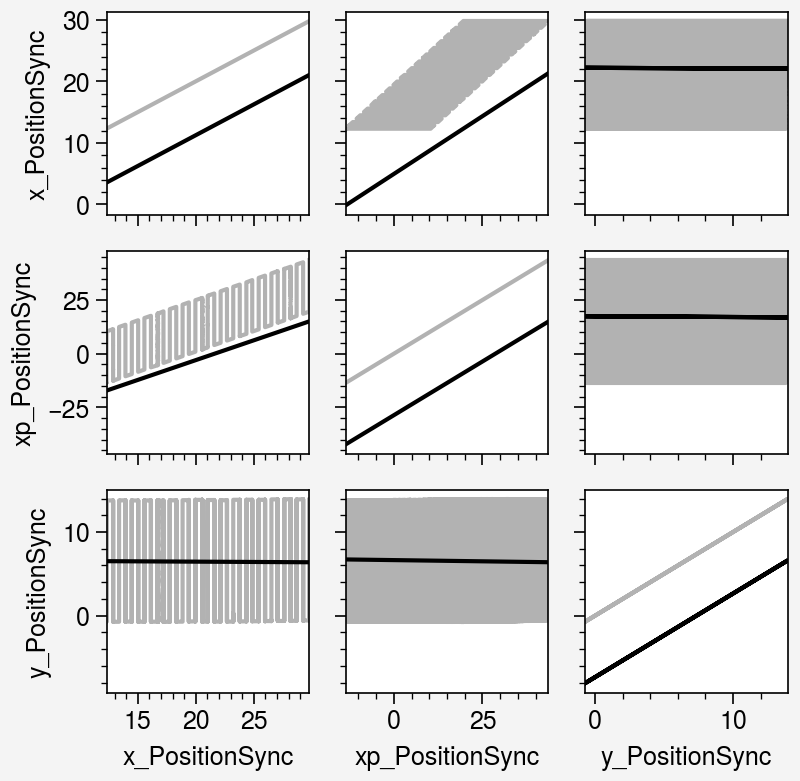

In [9]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=4.0, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        x = data_sc[acts[j]]
        y = data_sc[acts[i]]
        ax.plot(x, y, color='black', alpha=0.3)
        xmin, xmax = np.min(x), np.max(x)
        _x = x - 0.5 * (xmax - xmin)
        _y = corr[j, i] * _x + intercept[j, i]
        ax.plot(x, _y, color='black')
for i, act in enumerate(acts):
    axes[-1, i].set_xlabel(act)
    axes[i, 0].set_ylabel(act)
plt.show()

Work in the "normalized" (decorrelated) slit-screen coordinates. First, try transforming back to square grid.

In [10]:
# Shearing matrix 
ndim = 3
M = np.identity(ndim)
M[1, 2] = 1.9  # dxp / dx
Minv = np.linalg.inv(M)

# Center slit positions
d1_center = 6.5  # y
d2_center = 15.0  # xp
d3_center = 21.0  # x

center = np.array([d1_center, d2_center, d3_center])

Test on CSV file (planned points).

In [11]:
# Find out how many rows to skip. 
skiprows = 0
for line in open(join(datadir, filename + '.csv'), 'r'):
    if line.startswith('#'):
        skiprows += 1
print('skiprows =', skiprows)

# Read the CSV file.
names = []
for i in range(1, ndim + 1):
    names.extend([f'start{i}', f'stop{i}', f'step{i}'])
df = pd.read_csv(join(datadir, filename + '.csv'), 
                 skiprows=skiprows, sep='\s+', header=None, names=names)
df

skiprows = 23


,start1,stop1,step1,start2,stop2,step2,start3,stop3,step3
0,-0.75,13.75,2.266,-13.625,-13.625,0.0,12.25,12.25,0.0
1,13.75,-0.75,2.266,-12.875,-12.875,0.0,12.25,12.25,0.0
2,-0.75,13.75,2.266,-12.125,-12.125,0.0,12.25,12.25,0.0
3,13.75,-0.75,2.266,-11.375,-11.375,0.0,12.25,12.25,0.0
4,-0.75,13.75,2.266,-10.625,-10.625,0.0,12.25,12.25,0.0
...,...,...,...,...,...,...,...,...,...
1084,-0.75,13.75,2.266,40.625,40.625,0.0,29.75,29.75,0.0
1085,13.75,-0.75,2.266,41.375,41.375,0.0,29.75,29.75,0.0
1086,-0.75,13.75,2.266,42.125,42.125,0.0,29.75,29.75,0.0
1087,13.75,-0.75,2.266,42.875,42.875,0.0,29.75,29.75,0.0


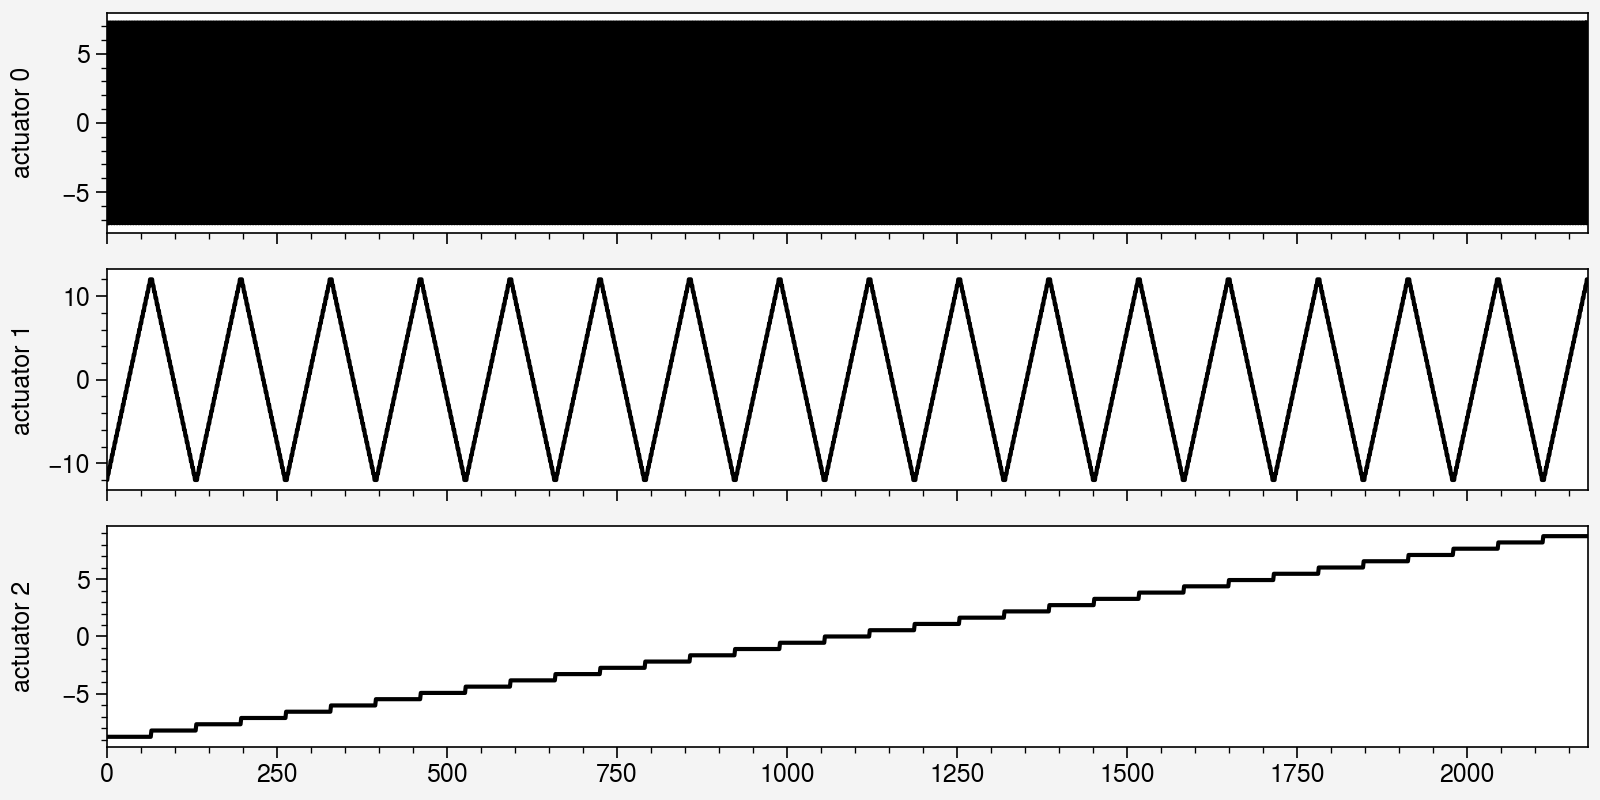

In [12]:
# Extract actuator points.
act_pts = [df.loc[:, [f'start{i}', f'stop{i}']].values.ravel() 
           for i in range(1, ndim + 1)]
act_pts = np.array(act_pts).T

# Undo linear transformation.
act_pts_n = np.apply_along_axis(lambda pt: np.matmul(Minv, pt - center), 1, act_pts)

# Plot actuator points in "normalized" space.
fig, axes = pplt.subplots(nrows=3, figsize=(8.0, 4.0), spany=False, aligny=True)
for i, ax in enumerate(axes):
    ax.plot(act_pts_n[:, i], color='black', lw=None, marker='.', ms=0)
    ax.format(ylabel=f'actuator {i}')

Create dataframe of actuator points.

In [13]:
dim_names = ['y1', 'x2', 'x1']
columns = []
for i, dim_name in enumerate(dim_names):
    columns.extend([dim_name, dim_name + '_n'])
df2 = pd.DataFrame(index=df.index, columns=columns)
for i, dim_name in enumerate(dim_names):
    df2[dim_name] = act_pts[::2, i]
    df2[dim_name + '_n'] = act_pts_n[::2, i]
df2

,y1,y1_n,x2,x2_n,x1,x1_n
0,-0.75,-7.25,-13.625,-12.00,12.25,-8.75
1,13.75,7.25,-12.875,-11.25,12.25,-8.75
2,-0.75,-7.25,-12.125,-10.50,12.25,-8.75
3,13.75,7.25,-11.375,-9.75,12.25,-8.75
4,-0.75,-7.25,-10.625,-9.00,12.25,-8.75
...,...,...,...,...,...,...
1084,-0.75,-7.25,40.625,9.00,29.75,8.75
1085,13.75,7.25,41.375,9.75,29.75,8.75
1086,-0.75,-7.25,42.125,10.50,29.75,8.75
1087,13.75,7.25,42.875,11.25,29.75,8.75


## Interpolation 

### Procedure for one bin

#### Group by (x, x') for a specified bin index

In [14]:
nstep = 11
GV = []  
BI = []  
for i, dim_name in enumerate(dim_names):
    gv, idx = utils.get_bins(act_pts_n, i, nstep, n_bins_mult=15)
    GV.append(gv)
    BI.append(idx)
    print(f'{dim_name}: {len(gv)} bins')

y1: 2 bins
x2: 33 bins
x1: 33 bins


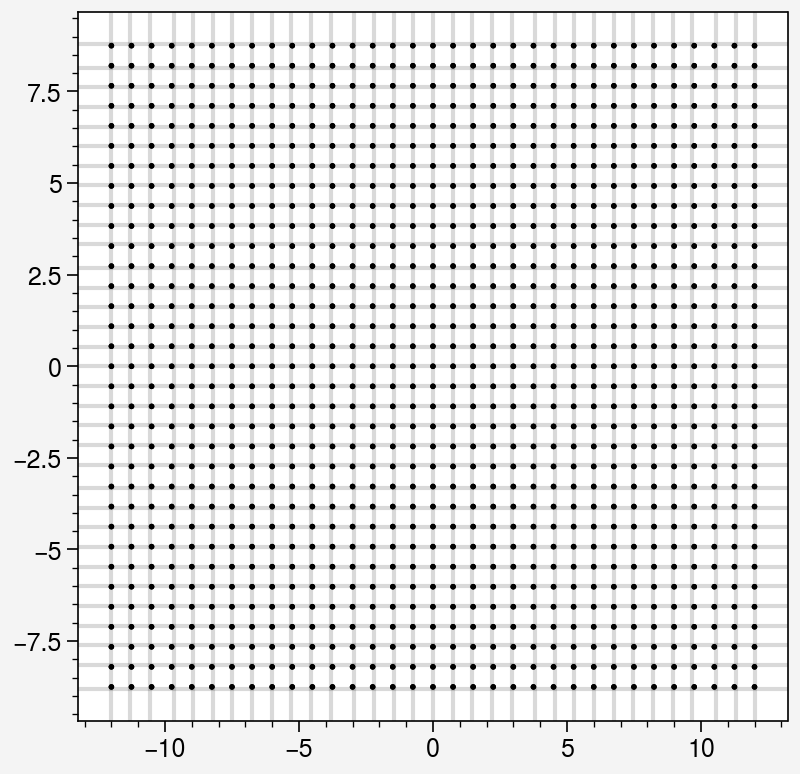

In [15]:
GV_X2_n, GV_X1_n = np.meshgrid(GV[1], GV[2], indexing='ij')

fig, ax = pplt.subplots(figwidth=4.0)
kws = dict(color='black', alpha=0.15)
for gv in GV[1]:
    ax.axvline(gv, **kws)
for gv in GV[2]:
    ax.axhline(gv, **kws)
ax.scatter(act_pts_n[:, 1], act_pts_n[:, 2], c='black', s=4, ec='None'); 
plt.show()

#### Group by (x, x') coordinates

`POINTS2D` holds iteration number on x2-x1 grid. (The number of iterations is half the number of sweeps.) Ordering: y, xp, x, yp, I.

In [16]:
POINTS2D = np.zeros((len(GV[2]), len(GV[1])))
POINTS2D[:] = np.nan
steps = []
iteration = 1
for i in range(len(GV[2])):
    for j in range(len(GV[1])):
        idx, = np.where((BI[1] == j) & (BI[2] == i))
        if len(idx) > 0:
            steps.append(idx)
            POINTS2D[i, j] = iteration
        else:
            print(f'Bin {i},{j} is empty')
        iteration += 1
POINTS2D = POINTS2D.astype(int)

[Explanation].

In [17]:
data_iteration = data_sc[:, 'iteration'].copy()
idx_bin = []
for i, step in enumerate(steps):
    indices = np.unique((step / 2 + 1).astype(int))
    idx = np.hstack([np.where(data_iteration == j)[0] for j in indices])
    idx_bin.append(np.unique(idx))

### Observe one sweep

In [18]:
iteration_peak, n_iterations = None, len(steps)
for iteration in range(n_iterations):
    if ipeak in idx_bin[iteration]:
        iteration_peak = iteration
        print(f'Peak is in iteration {iteration}')

Peak is in iteration 742


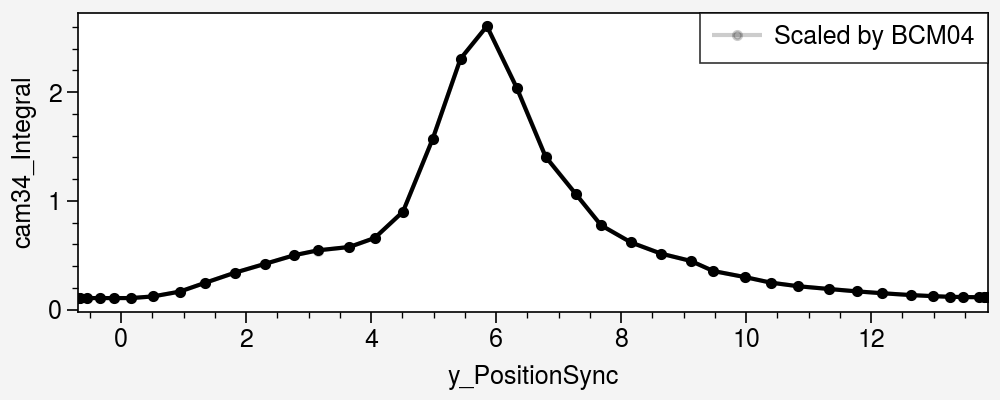

In [19]:
iteration = iteration_peak
bcm_mean = np.mean(data_sc[:, 'bcm04'])
scale = bcm_mean / data_sc[idx_bin[iteration], 'bcm04']

fig, ax = pplt.subplots(figsize=(5.0, 2))
ax.plot(
    data_sc[idx_bin[iteration], 'y_PositionSync'],
    data_sc[idx_bin[iteration], cam + '_Integral'],
    color='black', marker='.',
)
ax.plot(
    data_sc[idx_bin[iteration], 'y_PositionSync'],
    data_sc[idx_bin[iteration], cam + '_Integral'] * scale,
    color='black', marker='.', alpha=0.2,
    label='Scaled by BCM04',
)
ax.legend(loc='upper right')
ax.format(xlabel='y_PositionSync', ylabel=cam+'_Integral')
plt.show()

### Make GIF of sweep

We should either store the image in a square array in step 0, or somehow pass the new image shape to this notebook.

In [20]:
def get_image(index):
    return data_im[index, cam + '_Image'].reshape(ny, nx)

In [21]:
i_peak_sweep = np.argmax(data_sc[idx_bin[iteration], cam + '_Integral'])
norm_pixel_value = np.max(data_im[idx_bin[iteration][i_peak_sweep], cam + '_Image'])
cmap = pplt.Colormap('dusk_r')
greyscale = False
log = False

_ims = []
for i in tqdm(idx_bin[iteration]):
    _im = get_image(i) / norm_pixel_value
    if log:
        _im = np.log10(_im)
    if not greyscale:
        _im = cmap(_im)
    _ims.append(np.uint8(_im * np.iinfo(np.uint8).max))
imageio.mimsave(f'_output/iteration{iteration}_log{log}.gif', _ims, fps=6)

100%|██████████| 43/43 [00:00<00:00, 1240.15it/s]


### Smooth and interpolate along y_PositionSync 

We have snapped all points onto an x1-x2 grid. We now interpolate the y1 coordinate — the sweeping variable.

In [22]:
# Make the 3D image. 
n_frames = len(idx_bin[iteration])
im3d = np.zeros((n_frames, ny, nx))
for i in trange(n_frames):
    im3d[i, :, :] = get_image(idx_bin[iteration][i])
    
# Get y slit position at each frame.
yvals = data_sc[:, 'y_PositionSync'][idx_bin[iteration]]

# Apply a smoothing filter along the first dimension (y_PositionSync). 
im3d_smooth = ndimage.median_filter(im3d, size=(3, 1, 1), mode='constant', cval=0.0) 

100%|██████████| 43/43 [00:00<00:00, 5623.97it/s]


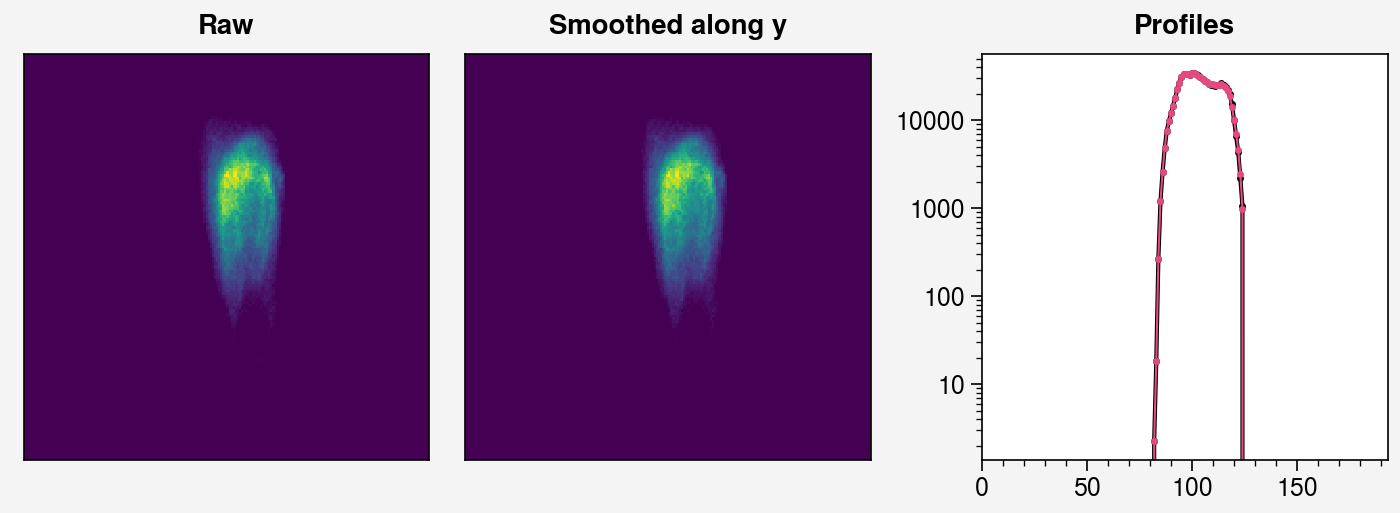

In [23]:
i = -10

fig, axes = pplt.subplots(ncols=3, figwidth=7, sharey=False)
axes[0].pcolormesh(im3d[i, :, :])
axes[1].pcolormesh(im3d_smooth[i, :, :])
axes[2].plot(np.sum(im3d[i, :, :], axis=0), color='black', marker='.', ms=3)
axes[2].plot(np.sum(im3d_smooth[i, :, :], axis=0), color='pink6', marker='.', ms=3, lw=0.75)
axes.format(toplabels=['Raw', 'Smoothed along y', 'Profiles'])
axes[:-1].format(xticks=[], yticks=[])
axes[-1].format(yscale='log')
plt.show()

### Interpolate to y grid

In [24]:
# Deal with backwards-moving slit.
idx_sort = np.argsort(yvals)
yvals = yvals[idx_sort]
im3d = im3d[idx_sort, :, :]
im3d_smooth = im3d_smooth[idx_sort, :, :]

# Deal with repeating points (otherwise interpolation will not work).
yvals = utils.avoid_repeats(yvals, pad=1e-7)
    
# Interpolate.
ygrid = np.linspace(np.min(yvals), np.max(yvals), N_PTS_Y)  
ypix = np.arange(ny) 
xpix = np.arange(nx) 
newpoints = utils.get_grid_coords(ygrid, ypix, xpix, indexing='ij')
arr3d = interpolate.interpn(
    (yvals, ypix, xpix), 
    im3d_smooth, 
    newpoints, 
    method='linear', 
    bounds_error=False, 
    fill_value=0.0
)
arr3d = arr3d.reshape(N_PTS_Y, ny, nx)

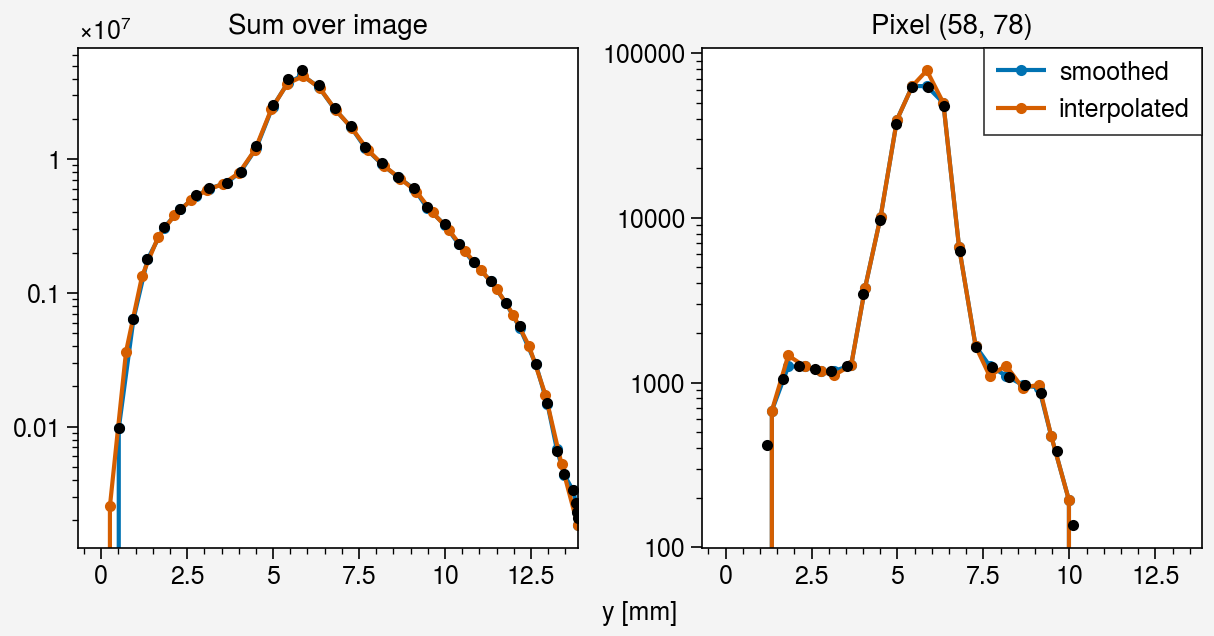

In [25]:
row, col = utils.max_indices(get_image(ipeak))

fig, axes = pplt.subplots(ncols=2, sharey=False,)
axes[0].plot(yvals, utils.project(im3d_smooth, 0), marker='.', label='smoothed')
axes[0].plot(ygrid, utils.project(arr3d, 0), marker='.', label='interpolated')
axes[0].plot(yvals, utils.project(im3d, 0), marker='.', lw=0, color='black')
axes[1].plot(yvals, im3d_smooth[:, row, col], marker='.', label='smoothed')
axes[1].plot(yvals, im3d[:, row, col], marker='.', label='interpolated')
axes[1].plot(ygrid, arr3d[:, row, col], marker='.', lw=0, color='black')
axes.format(yscale='log', xlabel='y [mm]')
axes[1].legend(loc='upper right', ncol=1,)
axes[0].format(title=f'Sum over image')
axes[1].format(title=f'Pixel ({row}, {col})')
plt.show()

Find the frame with the maximum pixel.

In [26]:
max1 = np.unravel_index(np.argmax(im3d), im3d.shape)[0]
max2 = 1 + np.unravel_index(np.argmax(arr3d), arr3d.shape)[0]  # why + 1?
row1, col1 = utils.max_indices(im3d[max1, :, :])
row2, col2 = utils.max_indices(arr3d[max2, :, :])
print(f'max1, row1, col1 = ({max1}, {row1}, {col1})')
print(f'max2, row2, col2 = ({max2}, {row2}, {col2})')

max1, row1, col1 = (20, 58, 78)
max2, row2, col2 = (14, 57, 80)


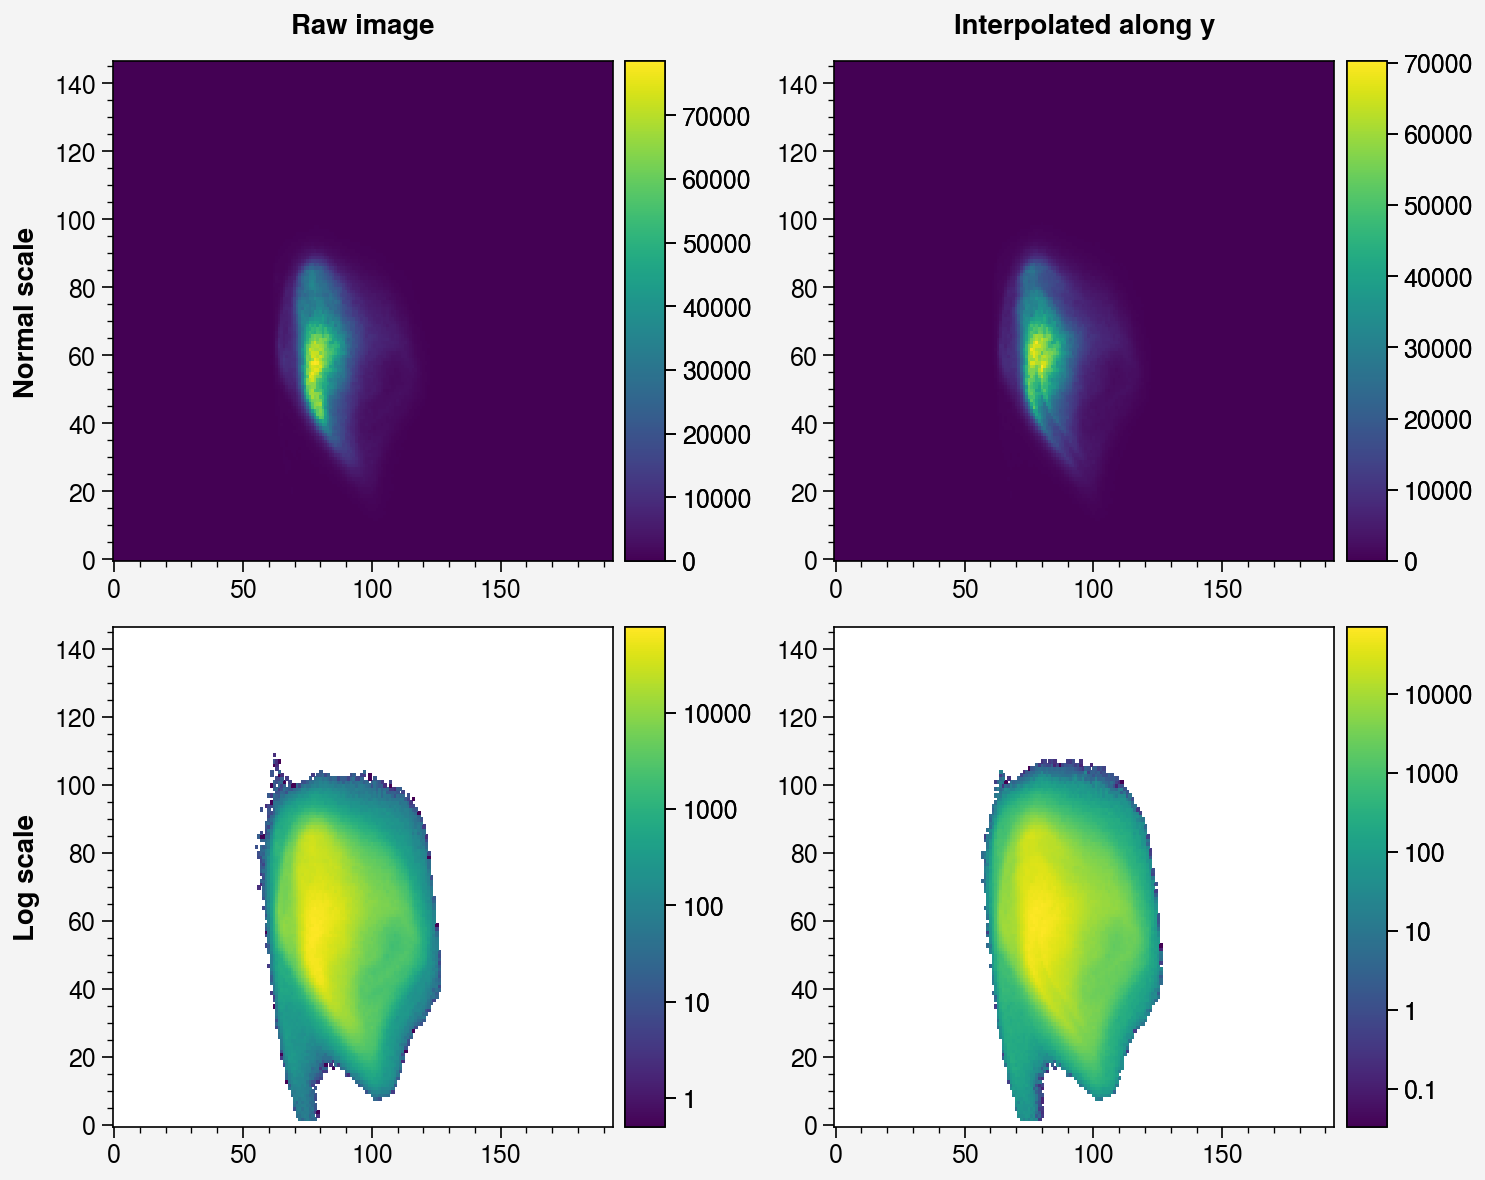

In [27]:
im1, im2 = im3d[max1], arr3d[max2]
fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
for col, _im in enumerate([im1, im2]):
    for row, log in enumerate([False, True]):
        norm = None
        if log:
            _im = np.ma.masked_less_equal(_im, 0)
            norm = 'log'
        axes[row, col].pcolormesh(_im, norm=norm, colorbar=True)
axes.format(leftlabels=['Normal scale', 'Log scale'],
            toplabels=['Raw image', 'Interpolated along y'])

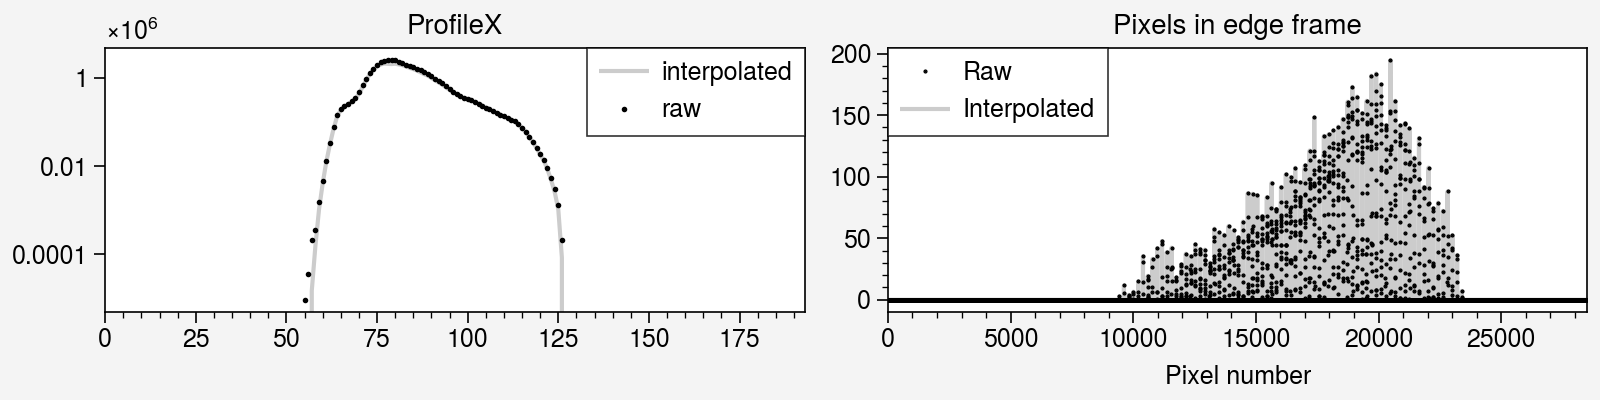

In [28]:
fig, axes = pplt.subplots(ncols=2, sharey=False, spanx=False, figsize=(8, 2))
axes[0].plot(np.sum(arr3d[max2, :, :], axis=0), color='black', alpha=0.2, label='interpolated')
axes[0].plot(np.sum(im3d[max1, :, :], axis=0), marker='.', ms=2, lw=0, color='black', label='raw')
axes[0].legend(ncol=1)
axes[0].format(yscale='log', title='ProfileX')
axes[1].plot(arr3d[-2, :, :].ravel(), marker='.', lw=0, color='black', ms=1, label='Raw')
axes[1].plot(arr3d[-2, :, :].ravel(), color='black', alpha=0.2, label='Interpolated')
axes[1].legend(loc='upper left', ncols=1)
axes[1].format(title='Pixels in edge frame', xlabel='Pixel number')

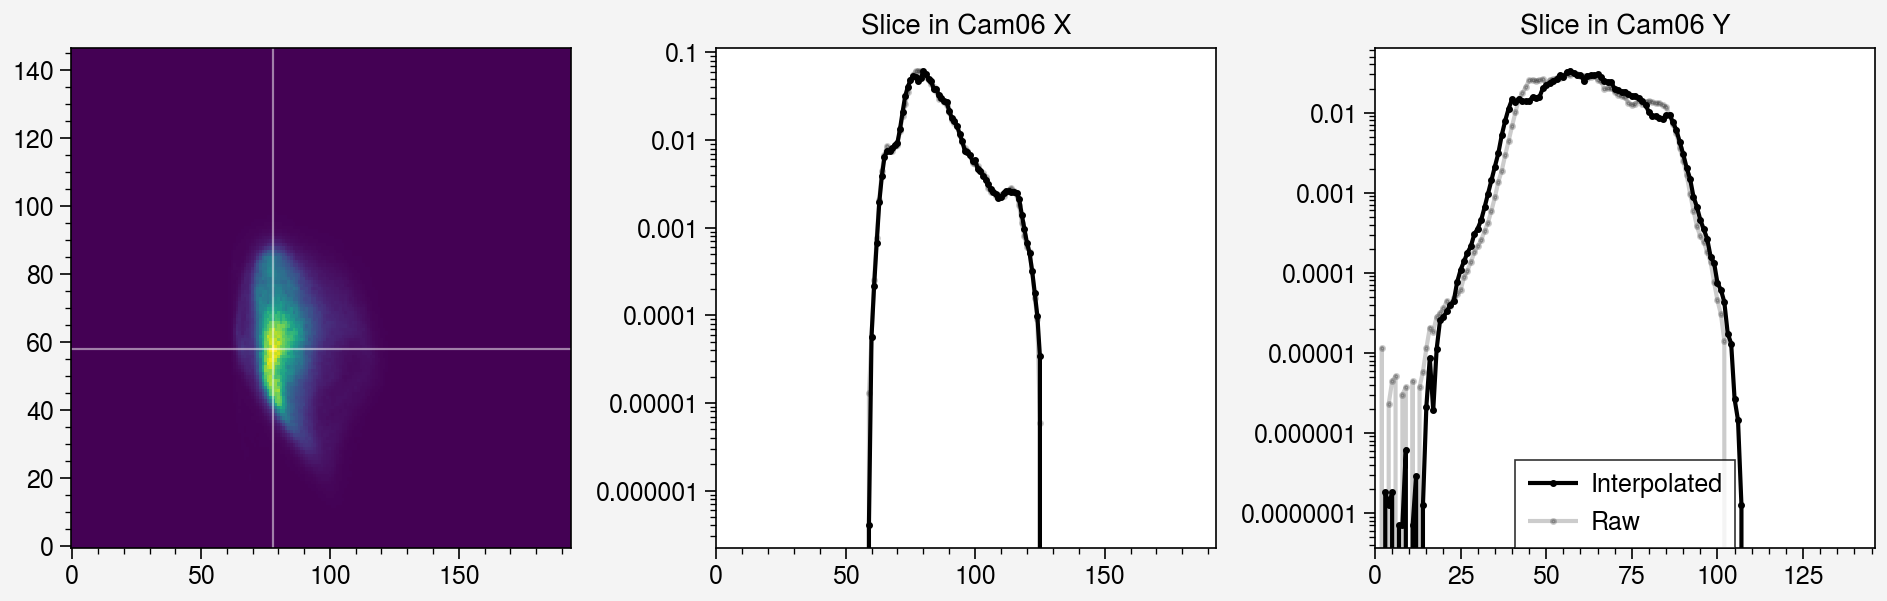

In [29]:
fig, axes = pplt.subplots(ncols=3, sharey=False, sharex=False)
axes[0].pcolormesh(im3d[max1, :, :])
kws = dict(color='white', lw=0.785, alpha=0.5)
axes[0].axvline(col1, **kws)
axes[0].axhline(row1, **kws)
kws = dict(marker='.', color='black')
for im, row, col, label in zip([arr3d[max2], im3d[max1]], [row2, row1], [col2, col1], ['Interpolated', 'Raw']):
    if label == 'Raw':
        kws['alpha'] = 0.2
        kws['lw'] = None
        kws['ms'] = 3.0
    elif label == 'Interpolated':
        kws['alpha'] = 1.0
        kws['lw'] = None
        kws['ms'] = 3.0
    axes[1].plot(im[row, :] / np.sum(im[row, :]), label=label, **kws)
    axes[2].plot(im[:, col] / np.sum(im[:, col]), label=label, **kws)
axes[2].legend(ncols=1)
axes[1].set_title('Slice in Cam06 X')
axes[2].set_title('Slice in Cam06 Y')
axes[1:].format(yscale='log')
plt.show()

## Save slit coordinates

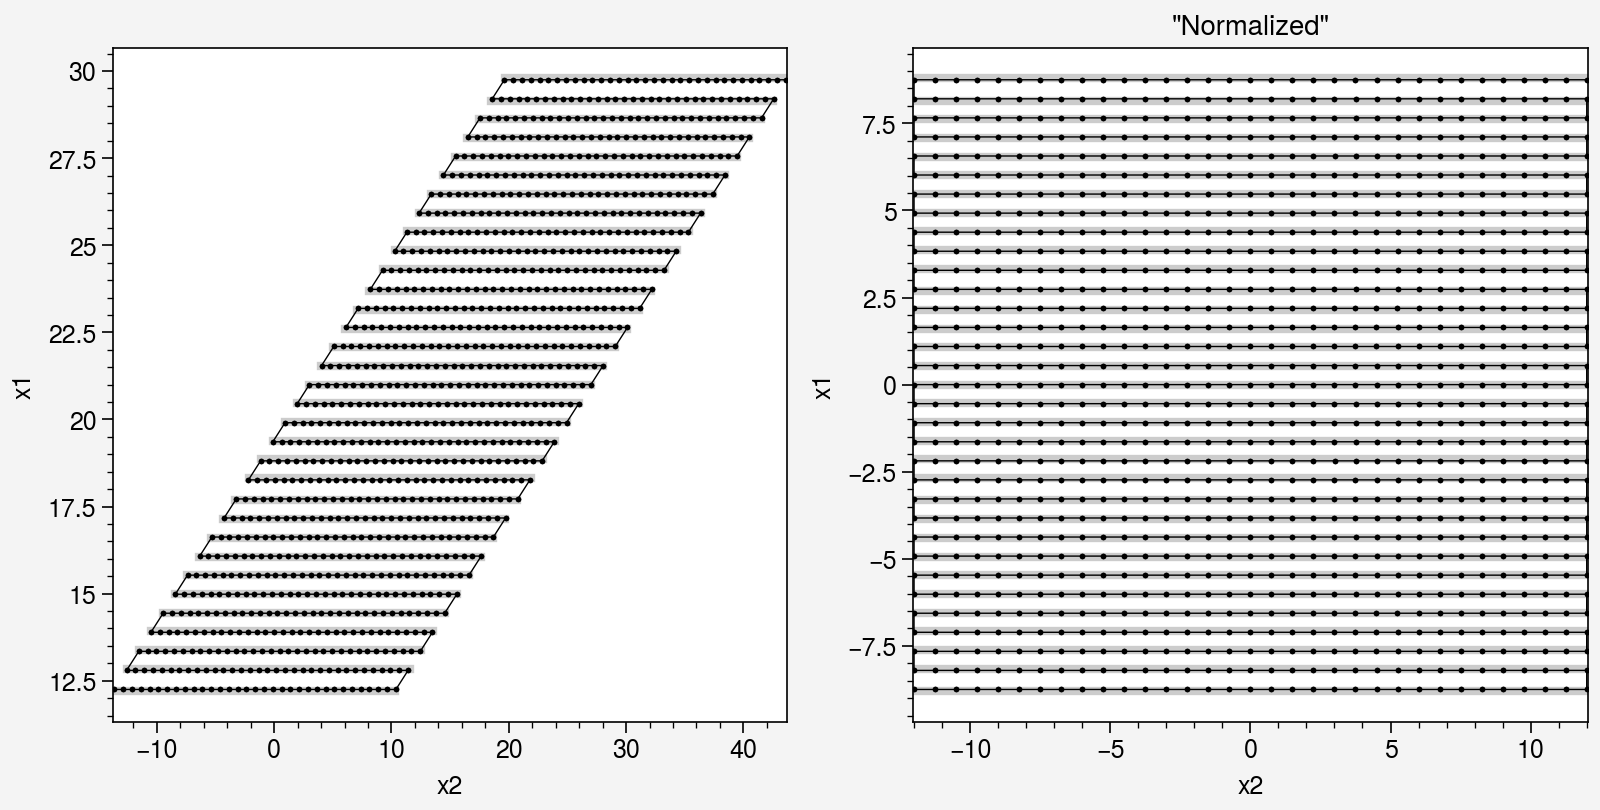

In [30]:
# ordering: y, xp, x
x2_x1_n = np.vstack([GV_X2_n.ravel(), GV_X1_n.ravel()]).T
x2_x1 = utils.apply(M[1:, 1:], x2_x1_n) + center[1:]
GV_X2 = x2_x1[:, 0].reshape(GV_X2_n.shape)
GV_X1 = x2_x1[:, 1].reshape(GV_X1_n.shape)

fig, axes = pplt.subplots(ncols=2, figwidth=8, sharey=False, sharex=False)
for ax, (grid1, grid2), pts in zip(axes, [(GV_X2, GV_X1), (GV_X2_n, GV_X1_n)], [act_pts, act_pts_n]):
    ax.plot(grid1[:], grid2[:], color='black', alpha=0.2, lw=3)
    ax.plot(pts[:, 1], pts[:, 2], color='black', marker='.', ms=2, lw=0.5)
axes.format(xlabel='x2', ylabel='x1')
axes[1].format(title='"Normalized"')

Define y grid.

In [31]:
y1 = data_sc[:, 'y_PositionSync']
ygrid = np.linspace(np.min(y), np.max(y), N_PTS_Y)

Obtain coordinates on the 3D grid.

In [32]:
X1 = np.repeat(GV_X1[:, :, np.newaxis], N_PTS_Y, axis=2)
X2 = np.repeat(GV_X2[:, :, np.newaxis], N_PTS_Y, axis=2)
Y1 = np.zeros(X1.shape)
for i in range(len(GV[2])):
    for j in range(len(GV[1])):
        Y1[i, j, :] = ygrid

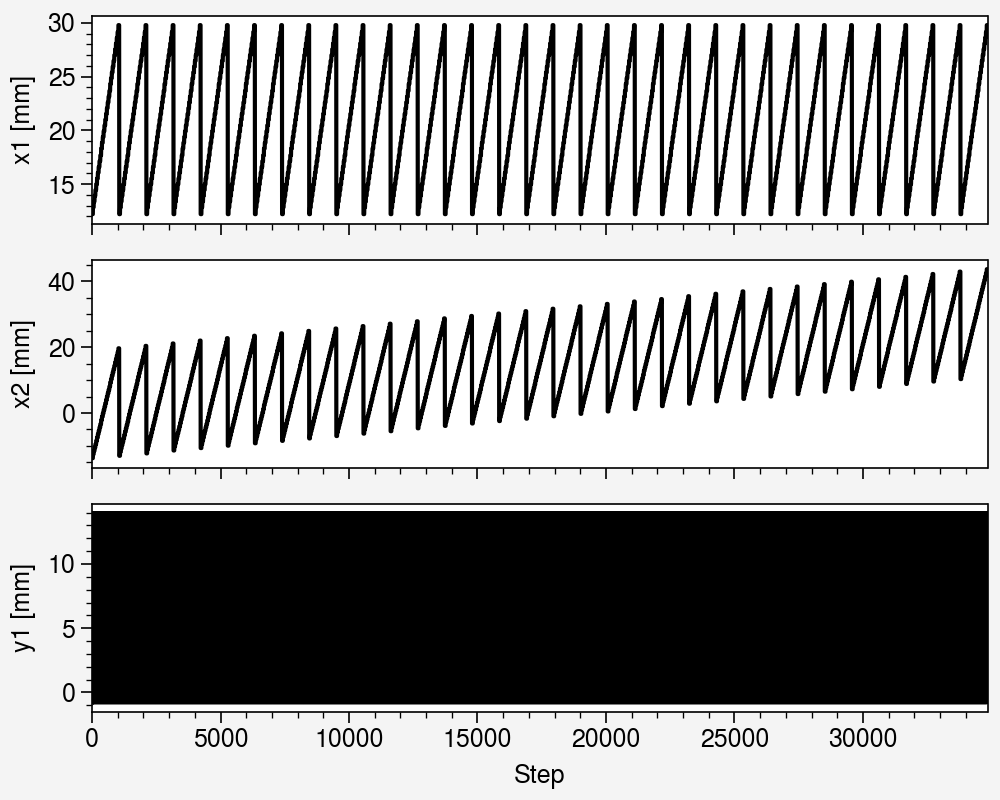

In [33]:
fig, axes = pplt.subplots(nrows=3, figsize=(5, 4), spany=False, aligny=True)
for ax, G, ylabel in zip(axes, [X1, X2, Y1], ["x1 [mm]", "x2 [mm]", "y1 [mm]"]):
    ax.plot(G.ravel(), color='black')
    ax.format(ylabel=ylabel)
axes.format(xlabel='Step')

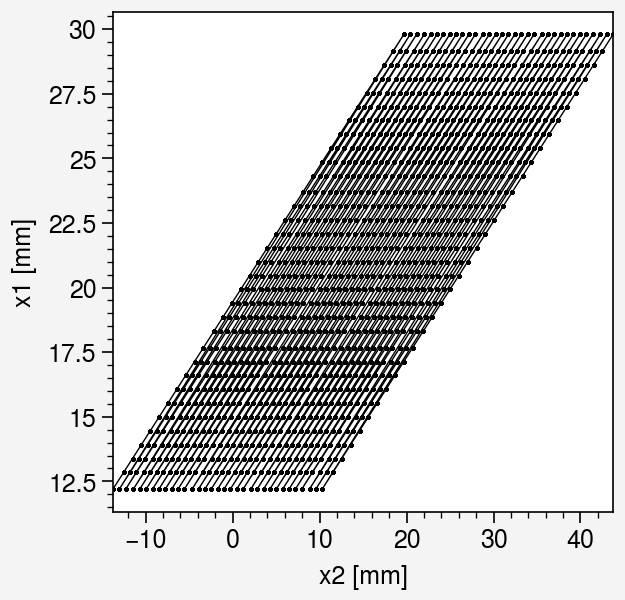

In [34]:
fig, ax = pplt.subplots()
ax.plot(X2.ravel(), X1.ravel(), color='black', marker='.', ms=1, lw=0.5)
ax.format(xlabel='x2 [mm]', ylabel='x1 [mm]')

In [35]:
coord_3d = np.stack([X1, X2, Y1], axis=0)
print(f'coord_3d.shape = {coord_3d.shape}')

coord_3d.shape = (3, 33, 33, 32)


In [36]:
savefilename = f'slit_coordinates_{filename}.npy'
np.save(savefilename, coord_3d)

## View projections and slices of data points in one iteration (sweep). 
coordinates y1, y3, x3

In [37]:
idx = idx_bin[iteration]
smooth = False
importlib.reload(ip)
a3d = ip.get_image_3d(data_im[idx, cam + '_Image'], data_sc[idx, 'y_PositionSync'], 
                      ygrid, ny, nx, smooth=smooth)

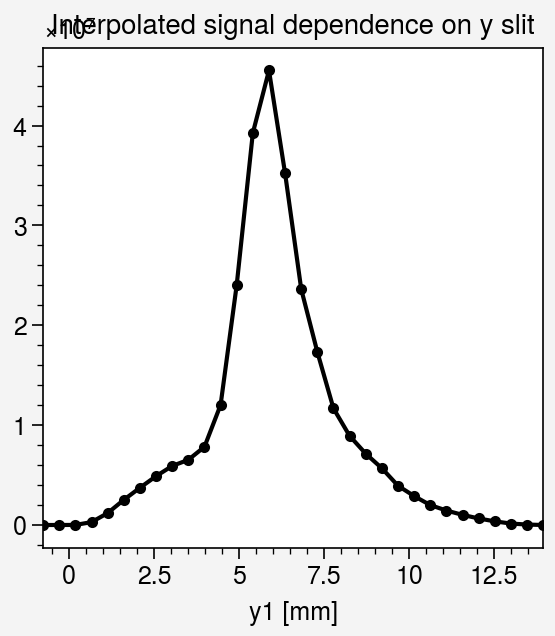

In [38]:
fig, ax = pplt.subplots()
ax.plot(ygrid, utils.project(a3d, 0), marker='.', color='black')
ax.format(xlabel='y1 [mm]', title='Interpolated signal dependence on y slit')

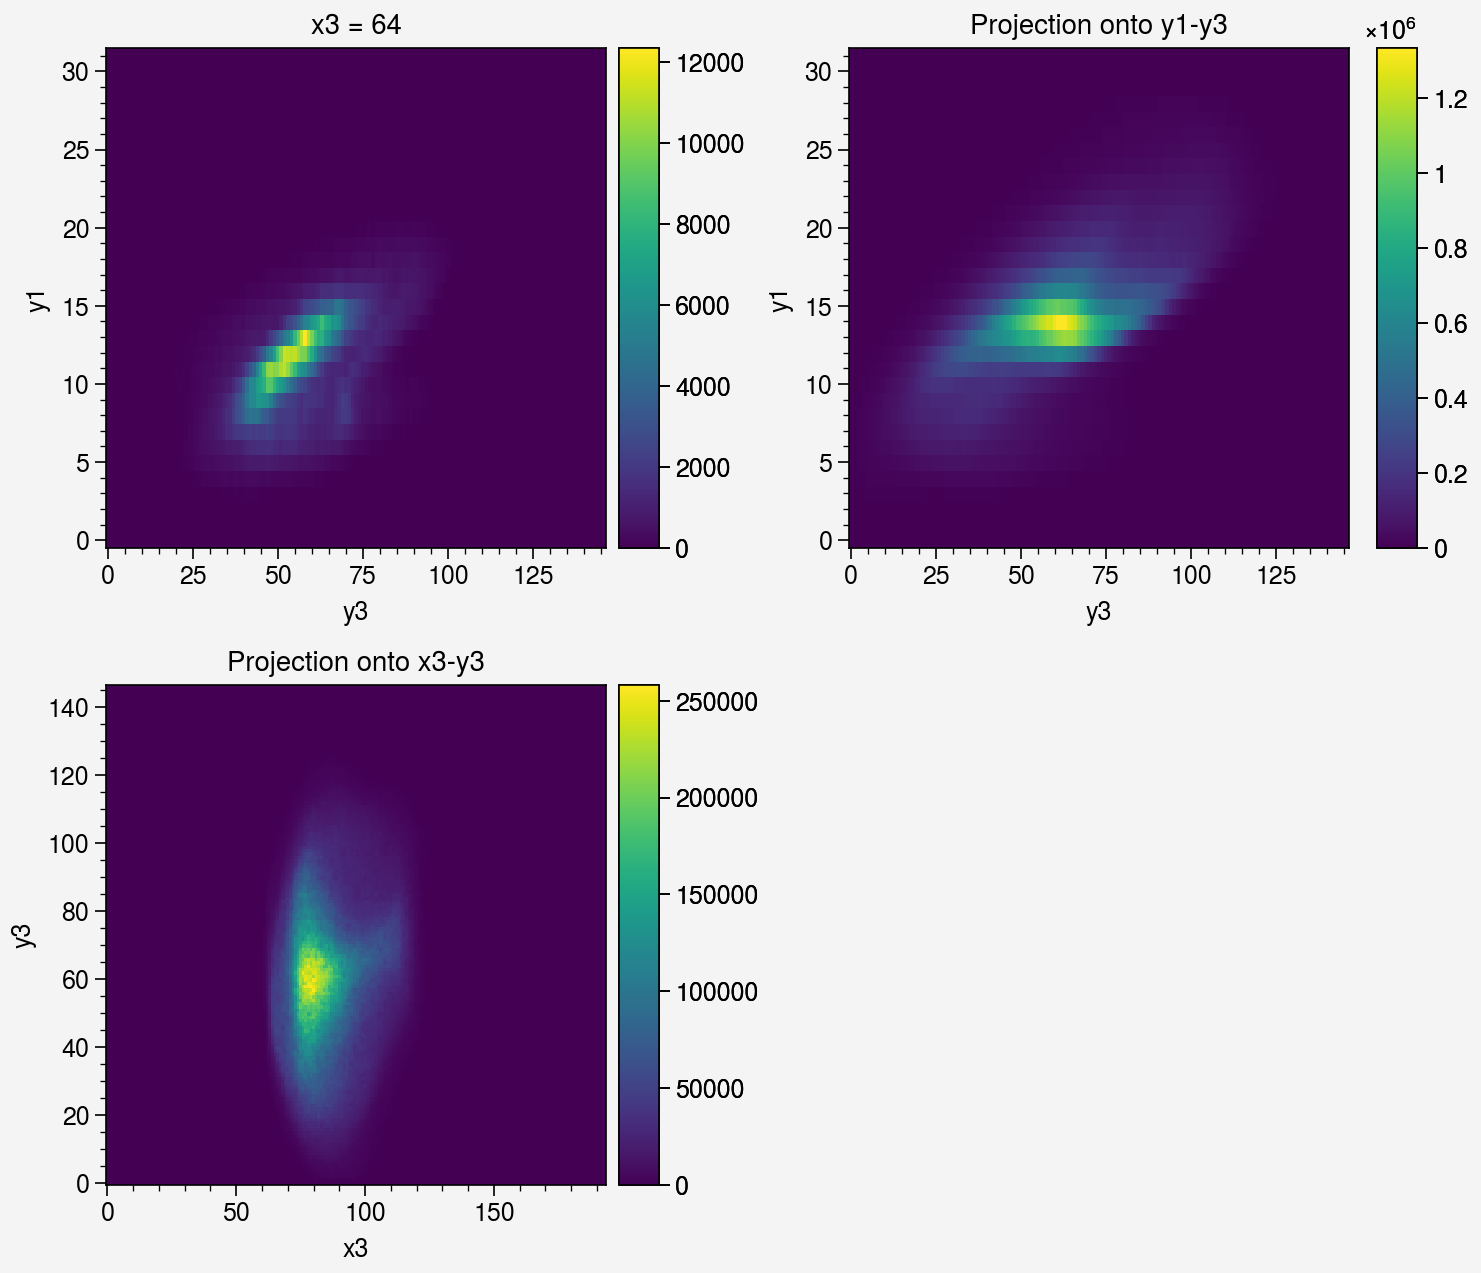

In [39]:
plot_kws = dict(discrete=False, colorbar=True)
fig, axes = pplt.subplots(nrows=2, ncols=2, sharex=False, sharey=False)
x3 = nx // 3
# x3 = 306
axes[0].pcolormesh(a3d[:, :, x3], **plot_kws)
axes[0].format(xlabel='y3', ylabel='y1', title=f'x3 = {x3}')
axes[1].pcolormesh(a3d.sum(axis=2), **plot_kws)
axes[1].format(xlabel='y3', ylabel='y1', title='Projection onto y1-y3')
axes[2].pcolormesh(a3d.sum(axis=0), **plot_kws)
axes[2].format(xlabel='x3', ylabel='y3', title='Projection onto x3-y3')
axes[3].axis('off')
plt.show()

## Save 5D array as memory map 

In [40]:
shape = [len(GV[2]), len(GV[1])] + list(a3d.shape)  # [x1, x2, y1, y3, x3]
shape = tuple(shape)
np.savetxt('rawgrid_shape.txt', shape)
print('shape:', shape)

shape: (33, 33, 32, 147, 194)


In [41]:
im_dtype = get_image(0).dtype
file = open('im_dtype.txt', 'w')
file.write(str(im_dtype))
file.close()
print('image dtype:', im_dtype)

image dtype: float64


In [42]:
savefilename = f'rawgrid_{filename}.mmp'
arrays_3d = np.memmap(savefilename, shape=shape, dtype=im_dtype, mode='w+') 
for i in trange(len(GV[2])):
    for j in range(len(GV[1])):
        try:
            idx = idx_bin[POINTS2D[i, j] - 1]
            arrays_3d[i, j, :, :, :] = ip.get_image_3d(
                data_im[idx, cam + '_Image'], 
                data_sc[idx, 'y_PositionSync'], 
                ygrid, ny, nx, smooth=False,
            )
        except IndexError:
            print(f'No points in grid bin ({i}, {j})')
            arrays_3d[i, j, :, :, :] = 0
del arrays_3d

100%|██████████| 33/33 [04:58<00:00,  9.06s/it]


## Visualization of 5D array

In [86]:
a5d = np.memmap(savefilename, shape=shape, dtype=im_dtype, mode='r')

### Slices across beam center

In [44]:
a5d_max = np.max(a5d)
ind_max = utils.max_indices(a5d)  # indices of maximum element in a5d
ix1, ix2, iy1, iy2, ix3 = ind_max
labels = ['x1', 'x2', 'y1', 'y3', 'x3']
print(f'Peak value = {a5d_max} at index {ind_max}')

Peak value = 114482.0 at index (22, 17, 13, 57, 68)


In [45]:
def plot_log(im, xlabel='', ylabel=''):
    fig, axes = pplt.subplots(ncols=2)
    for ax, log in zip(axes, [False, True]):
        norm = None
        if log:
            im = np.ma.masked_less_equal(im, 0)
            norm = 'log'
        ax.pcolormesh(im, norm=norm, colorbar=True)
    axes.format(xlabel=xlabel, ylabel=ylabel)
    return axes

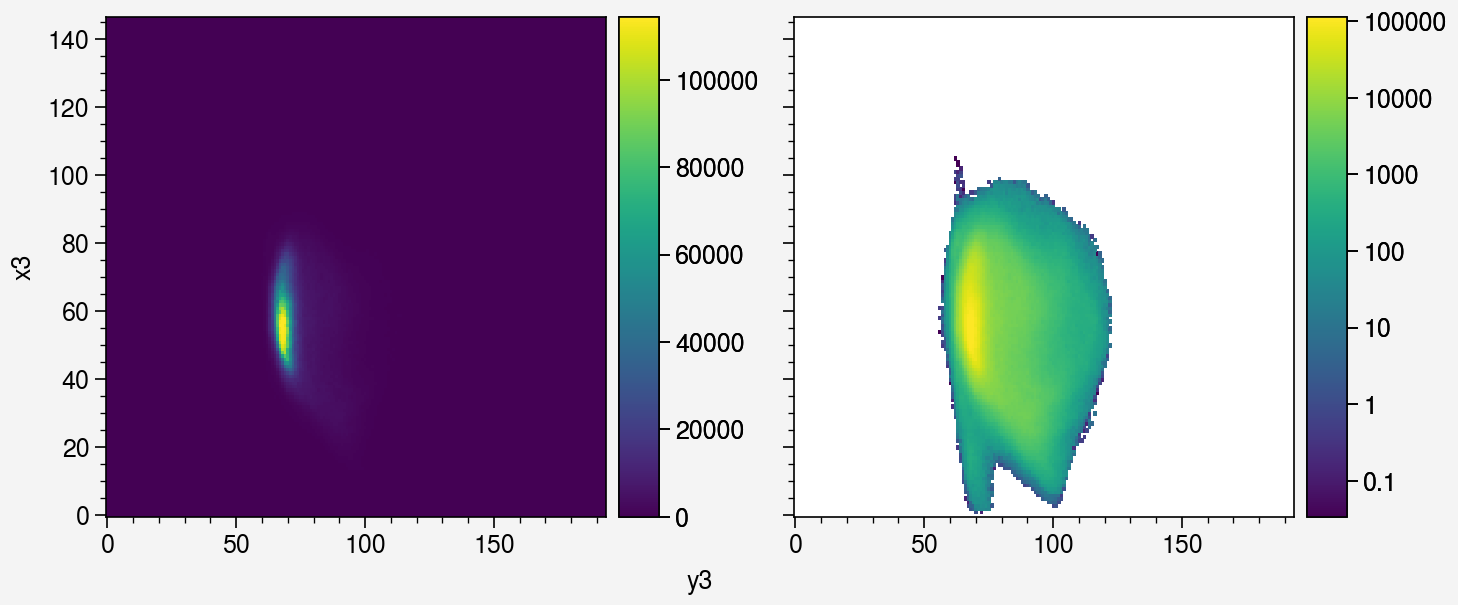

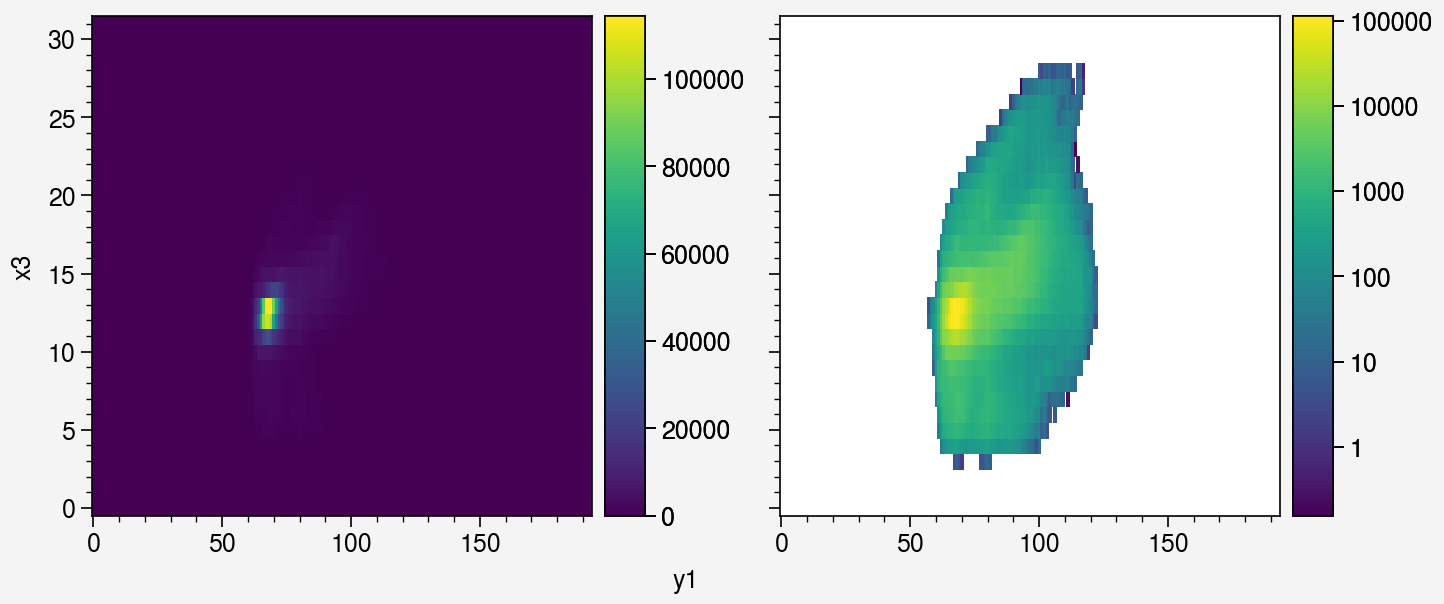

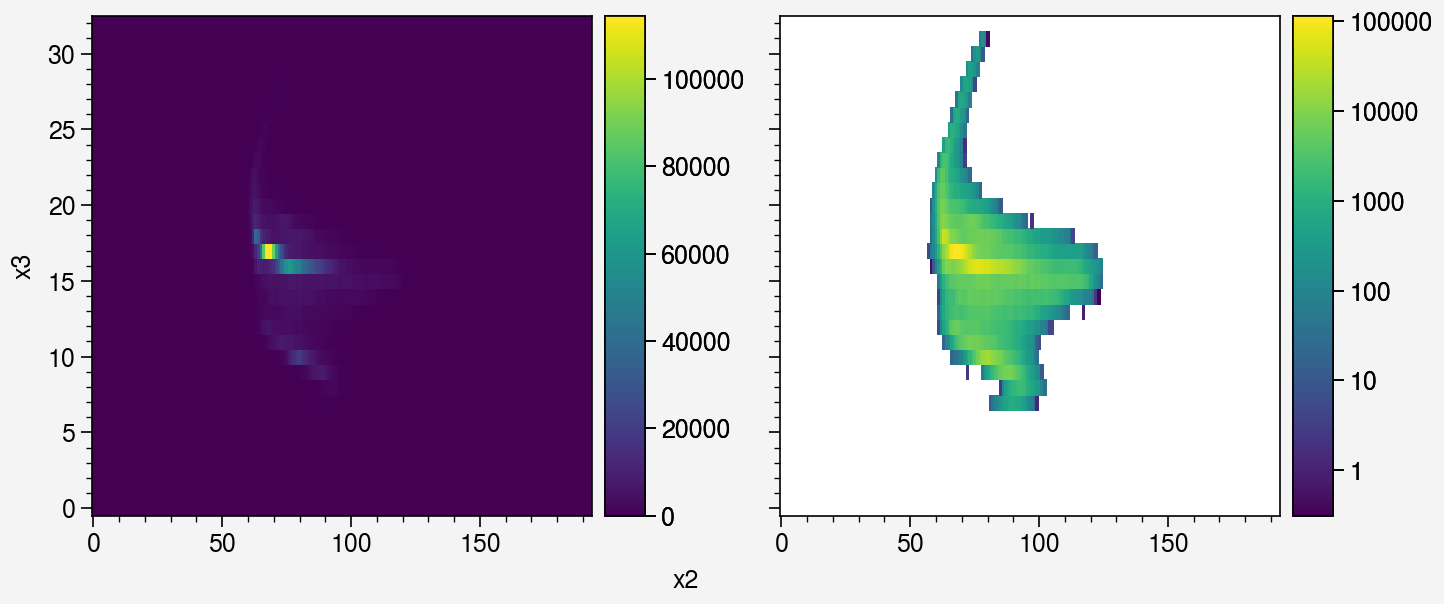

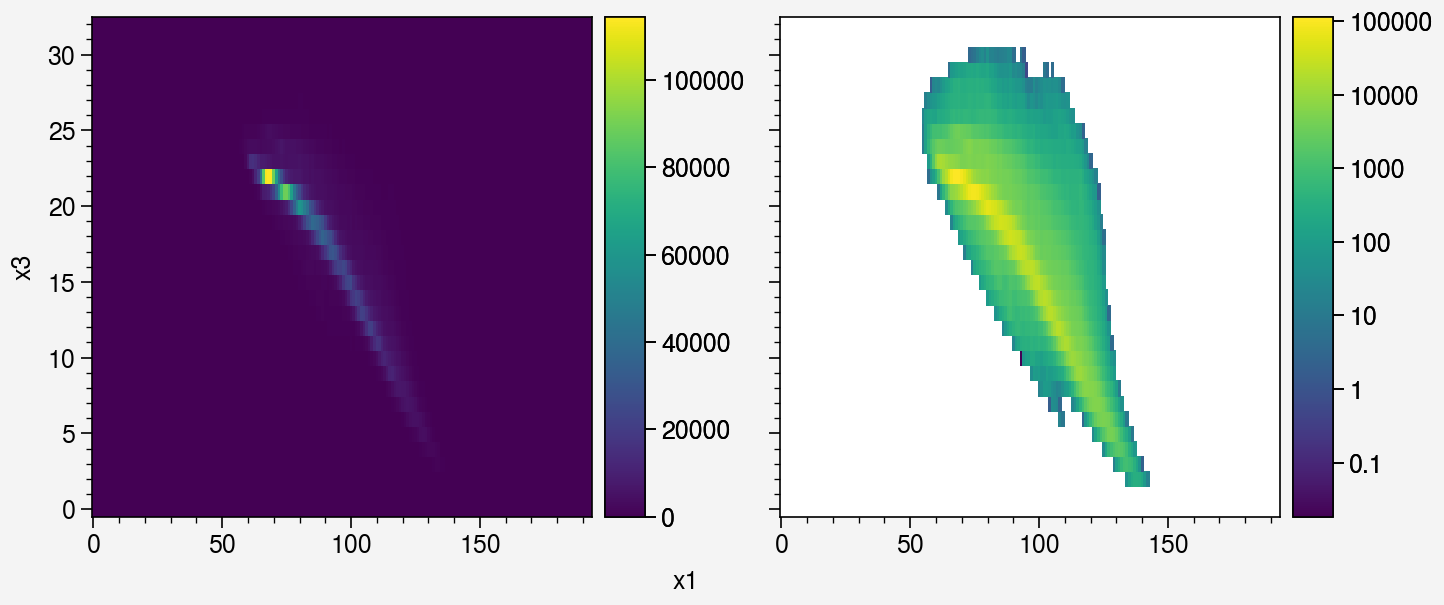

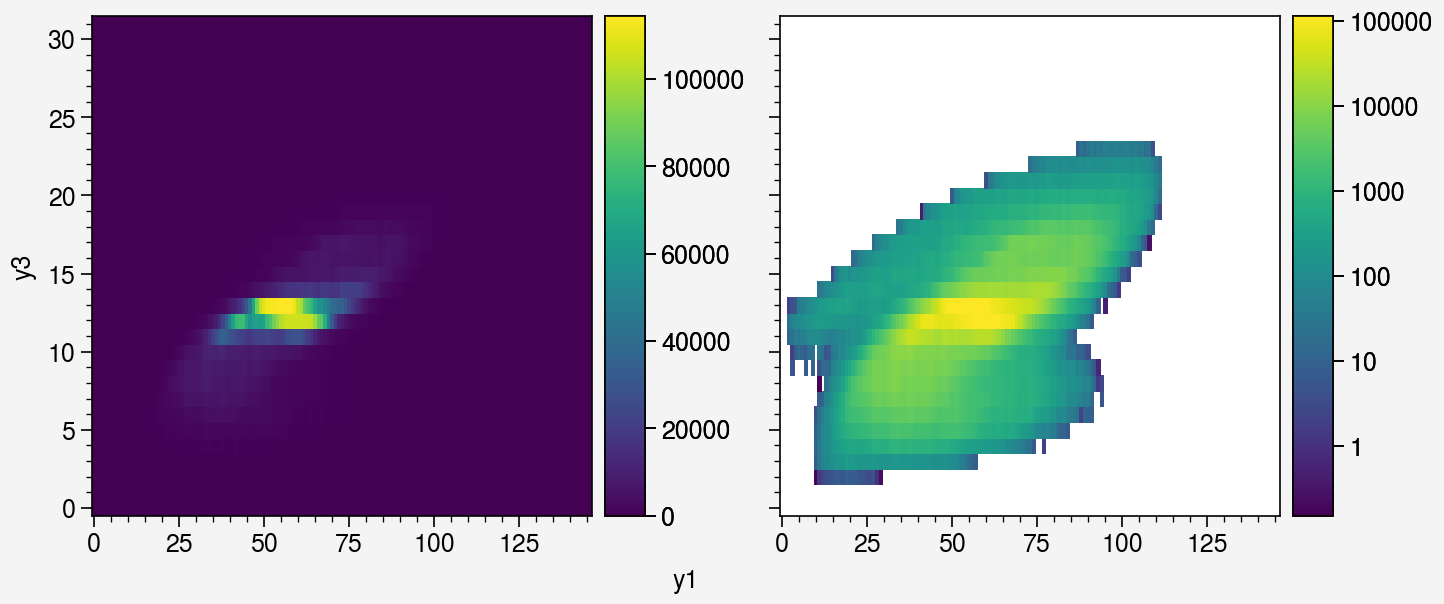

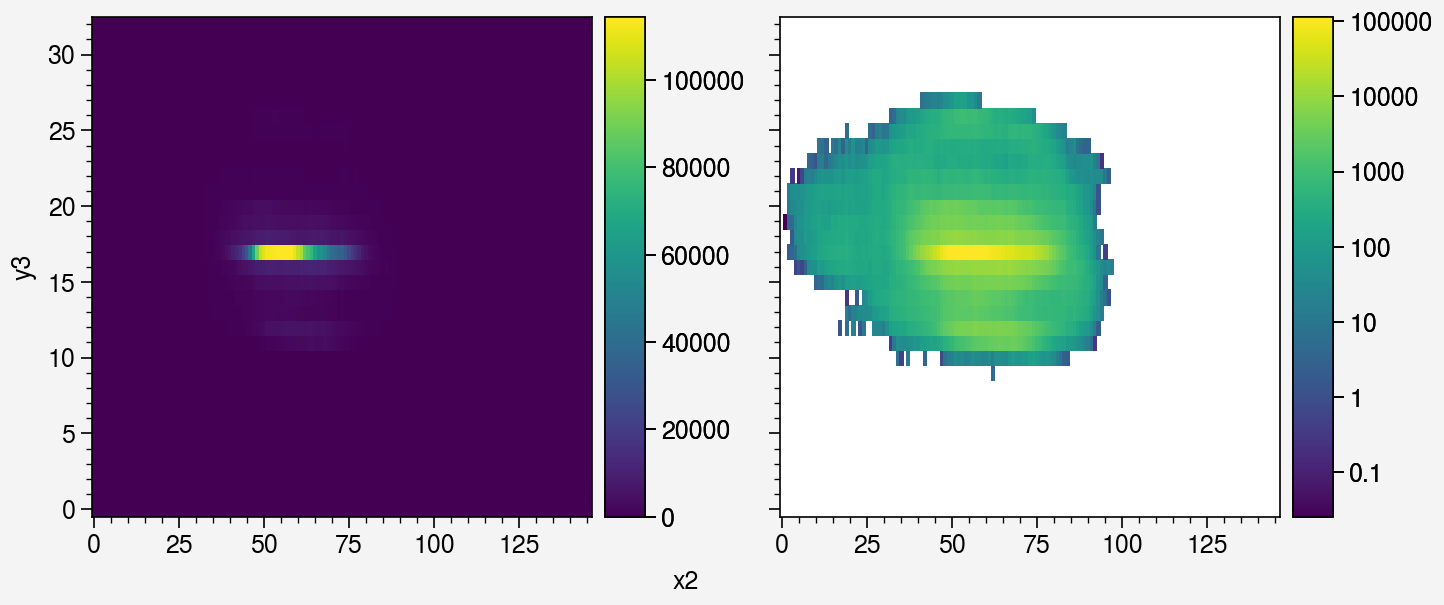

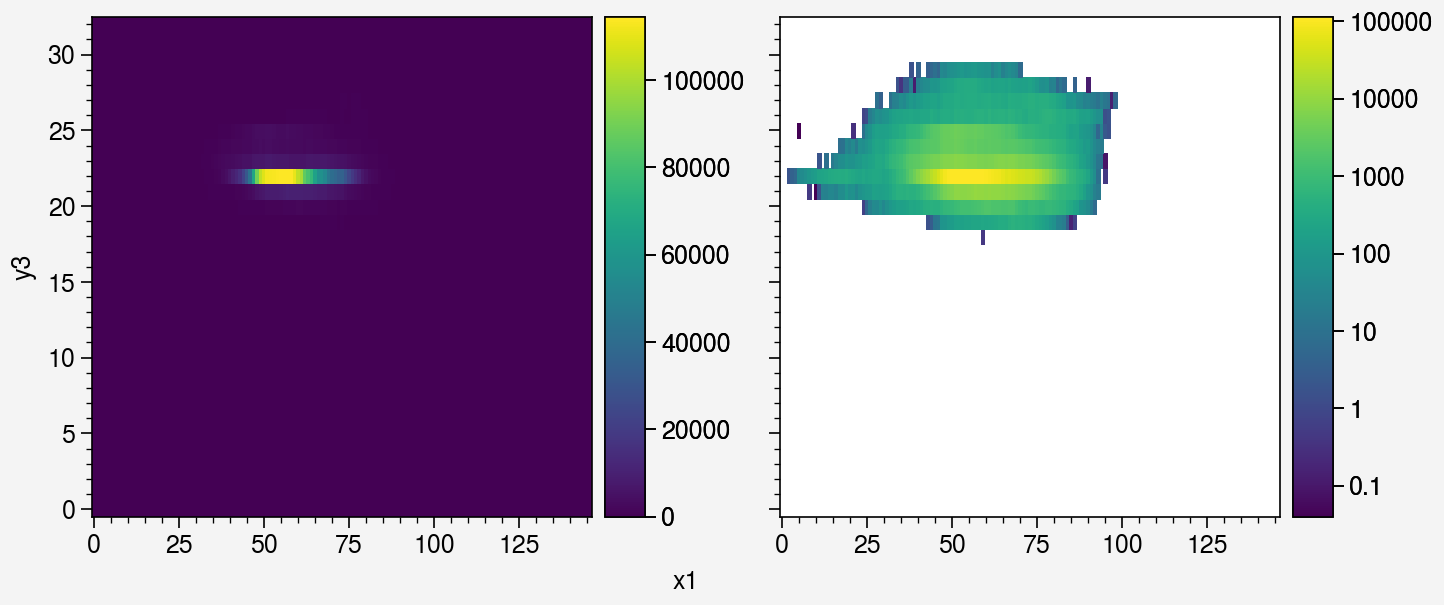

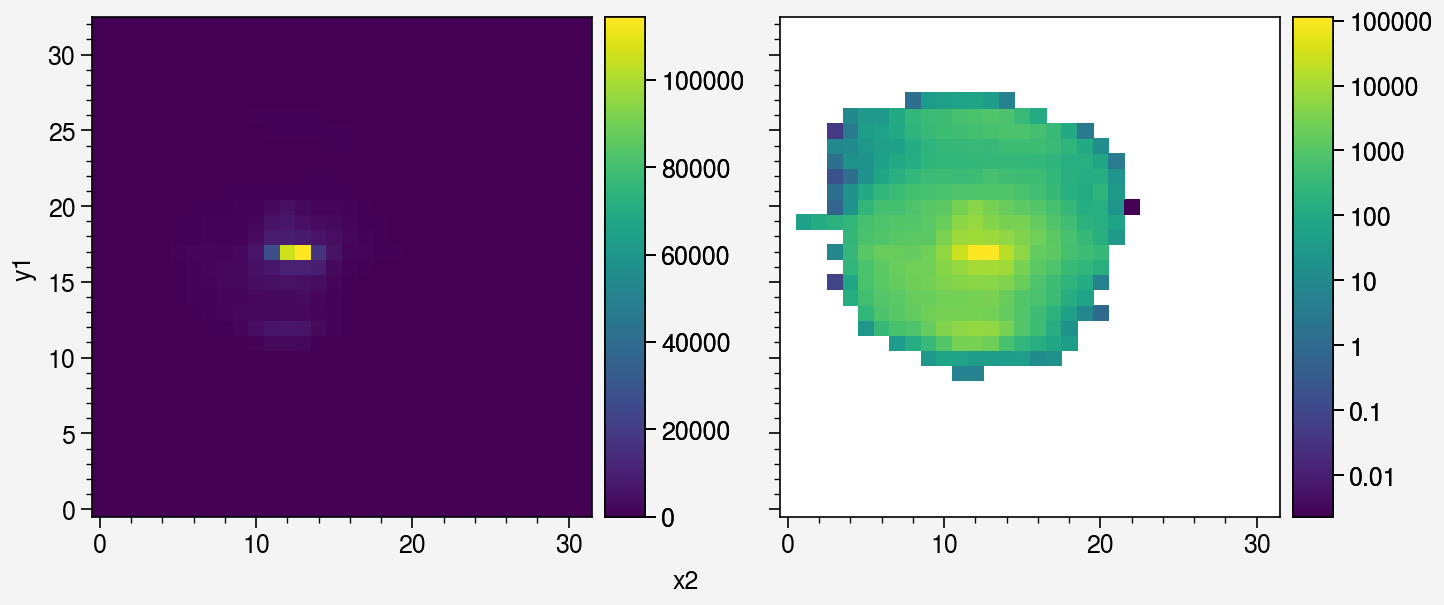

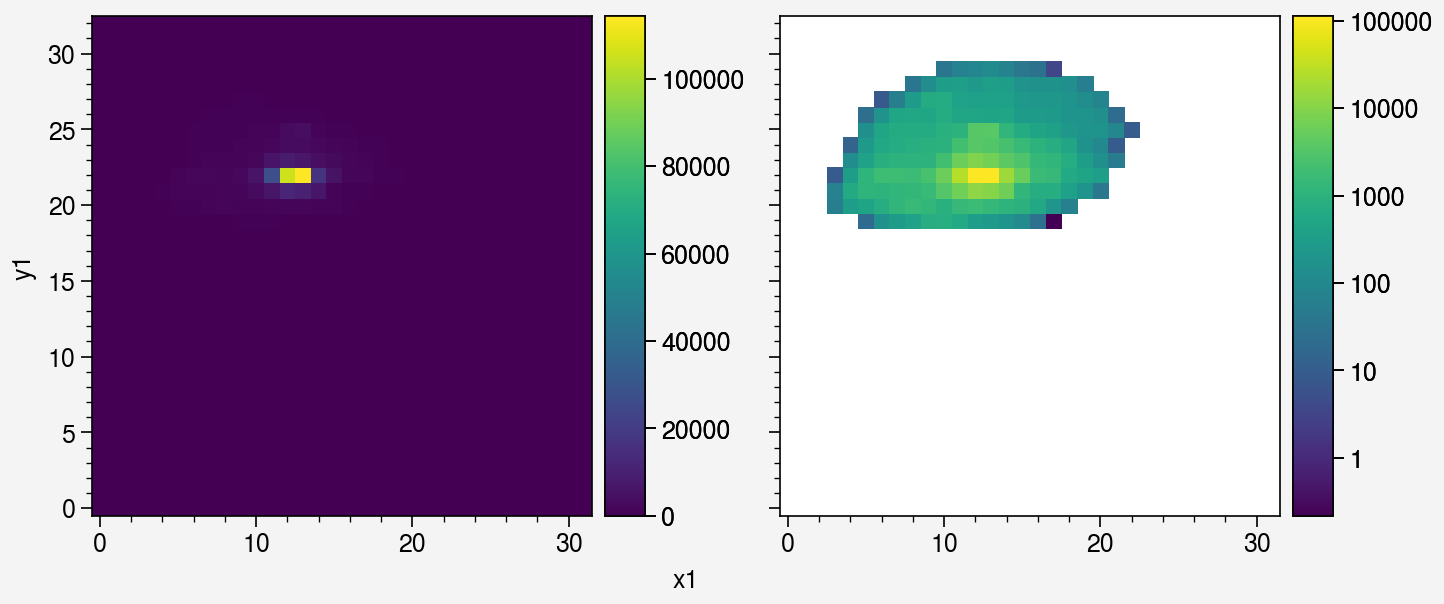

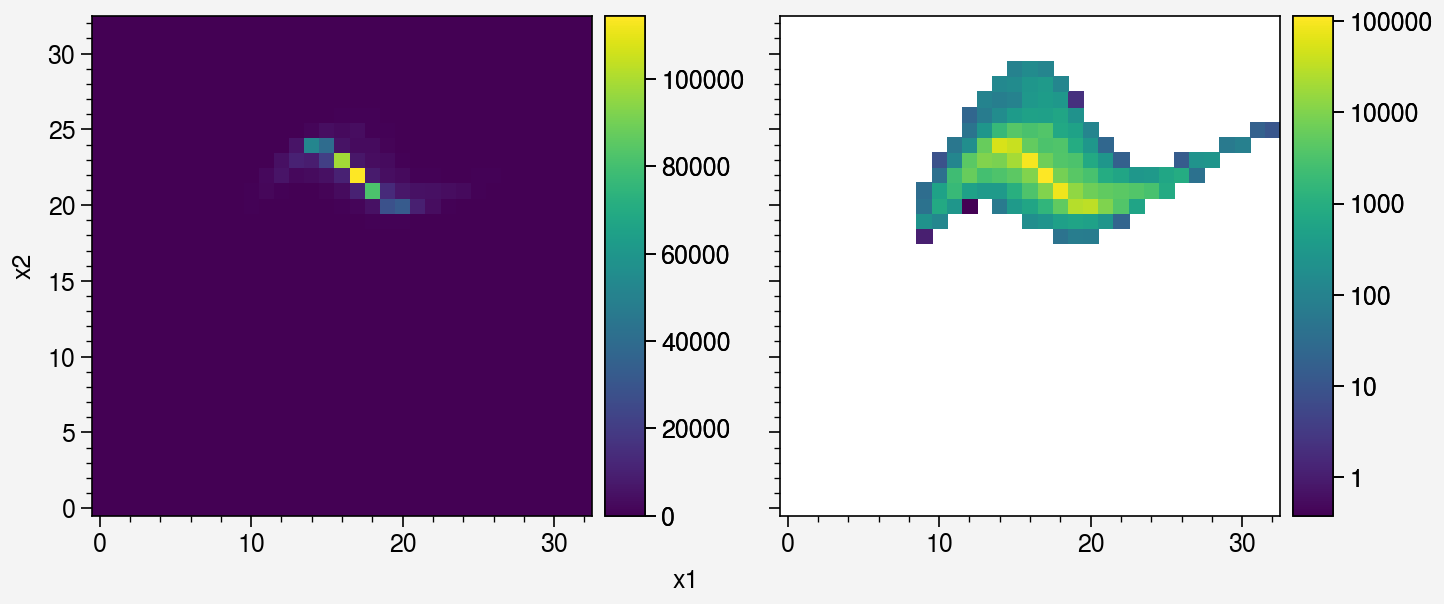

In [46]:
axes_slice = [(k, j, i) for i in range(5) for j in range(i) for k in range(j)]
for axes in axes_slice:
    axes_not_slice = [axis for axis in range(5) if axis not in axes]
    xlabel, ylabel = [labels[axis] for axis in axes_not_slice]
    ind = [ind_max[axis] for axis in axes]
    a5d_slice = utils.slice_array(a5d, axes, ind)
    plot_axes = plot_log(a5d_slice.copy(), xlabel, ylabel)
    plt.show()

### Projections

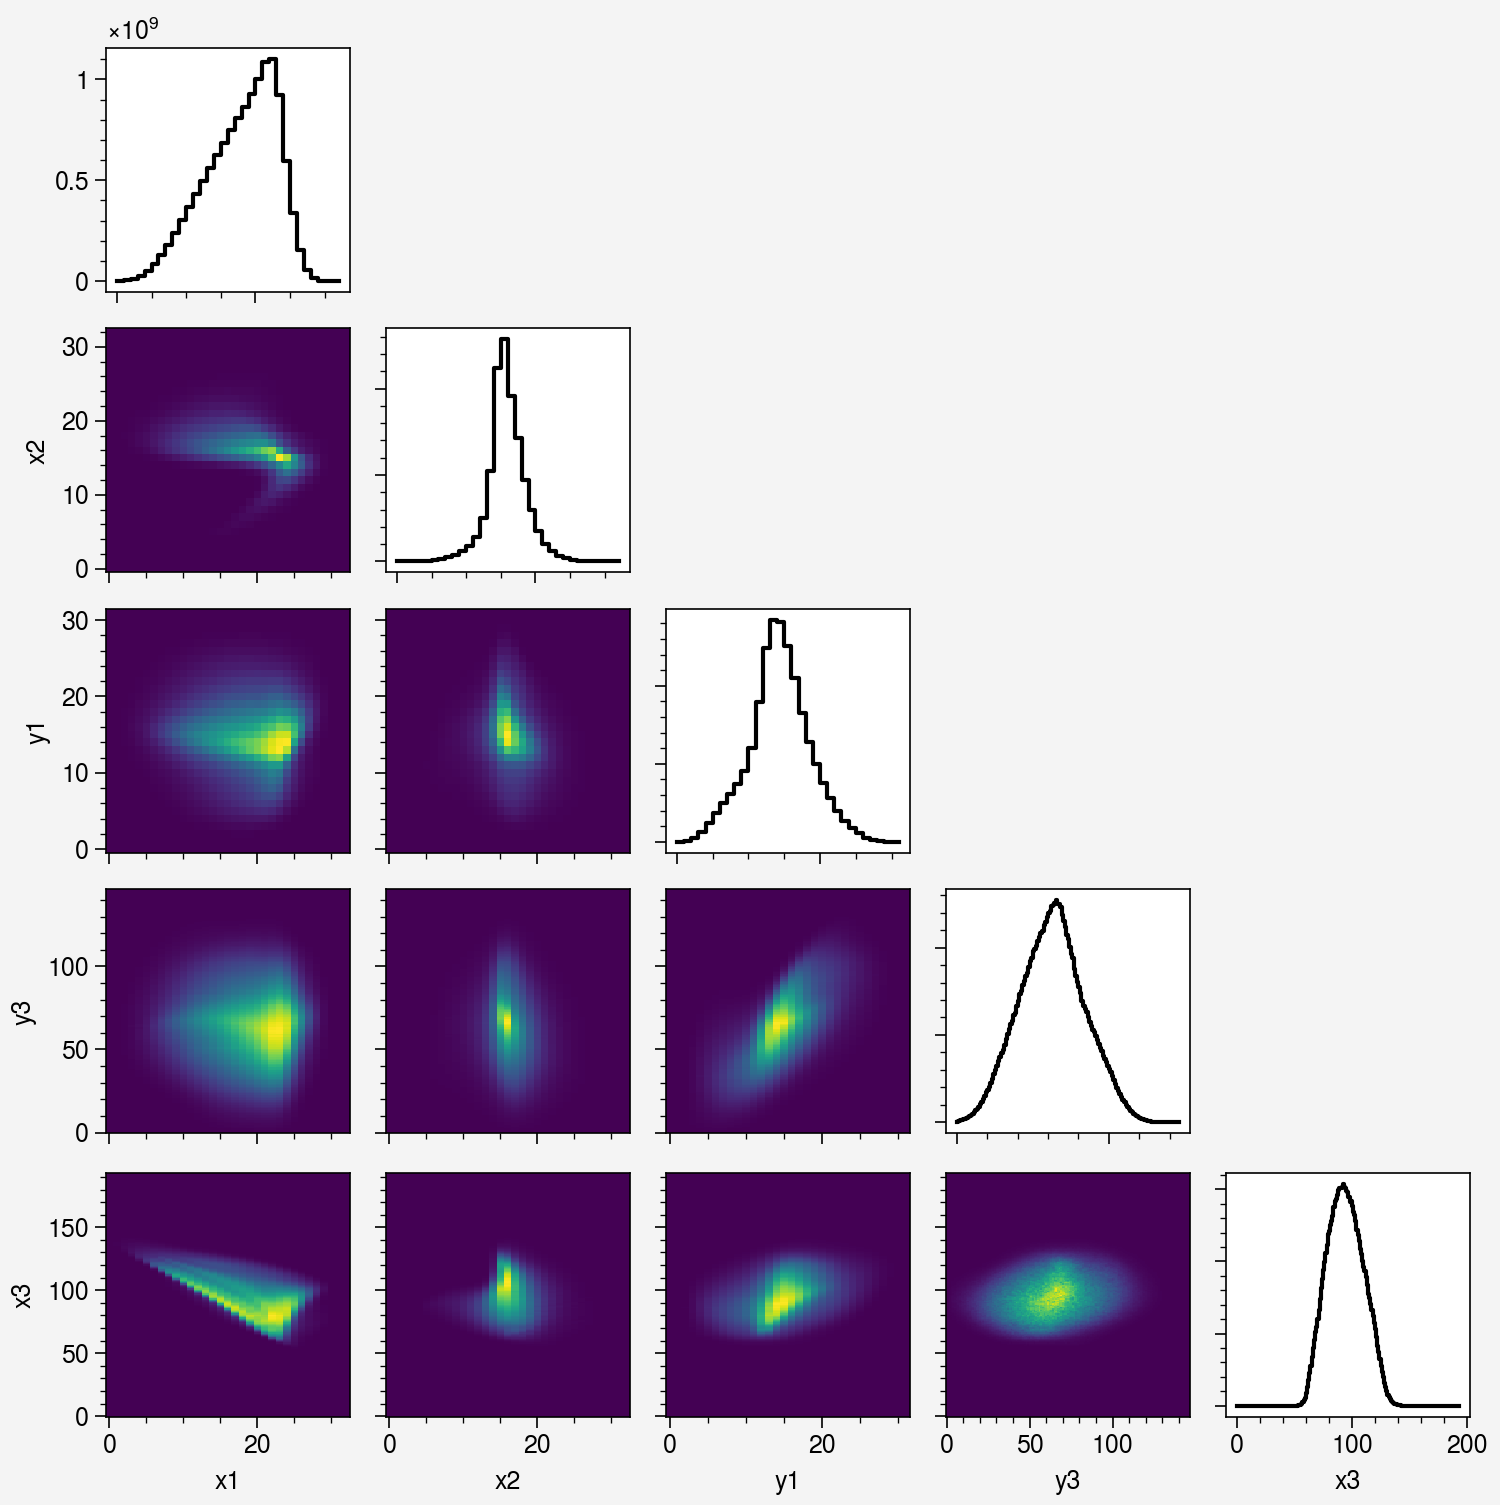

In [90]:
axes = mplt.corner(a5d, labels=labels, diag_kind='step')
plt.savefig('_output/corner_raw.png')

In [85]:
del a5d